# **0: Connecting to Google Drive and Github**

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


##### Github

In [107]:
# !git init real_estate_uni_bivariable

In [108]:
# %cd real_estate_uni_bivariable

In [109]:
# %ls -a

In [110]:
# !git status

In [111]:
# !git add .

In [112]:
# !git commit -m "new commit"

# **Dataset 1: Página web de anuncios inmobiliarios -> ASKING PRICE**

## **Consideraciones iniciales o punto de partida**

**VARIABLE DEPENDIENTE:** el precio de venta (asking-price). La variable se llama "PRICE".

Este análisis se realiza para conocer el precio de venta de apartamentos (también conocido como Asking Price) que los vendedores están publicando en los anuncios de una página web de anuncios inmobiliarios. El objetivo es poder predecir el precio de venta de un inmueble concreto en función de sus características.
*   Se ha extraído una muestra de la población de datos que se quiere analizar. La muestra coincide con las características del inmueble que se quiere predecir. Se ha de tener en cuenta que el mercado inmobiliario de esta región es muy particular y existen grandes variaciones en el precio entre localidades cercanas.
*   En cuanto al tipo de inmueble, no se han analizado casas individuales ni adosados, sólo apartamentos (ya sean estudios, apartamentos de una habitación, de dos habitaciones, duplex o triplex. También apartamentos de nueva construcción).
*   Respecto al precio, se ha establecido un rango entre 0 y 300.000, ya que es el rango de precios que nos interesa, además, debido a problemas con el web scraping, no hemos podido ampliar esta lista para incluir otro tipo de inmuebles o aquellos con un precio superior. Es por ello que no ha sido necesario hacer un estudio de los outliers.
*   El dataset es muy pequeño (unas 180 líneas) ya que la zona geográfica está muy restringida. Se han recopilado datos durante 2 meses, desde el 29 de junio hasta el 29 de agosto, y se han añadido 3 nuevas columnas al final del dataset para gestionar los movimientos ocurridos a lo largo del tiempo: sold (y/n), selling_time (se ha calculado manualmente el tiempo transcurrido entre la aparición del anuncio y su desaparición) y old_price (se han registrado los cambios en el precio de venta, al alza o a la baja).
*   Al tener tan pocas filas, corro el riesgo real (y así se confirma desde las primeras pruebas) de incurrir en overfitting. Es por ello que voy a simplificar el algunas columnas, aquellas que salen de la variable general "tags", para intentar llegar a la parte de ejecución de los modelos con menos columnas. En concreto hago que las variables "chambres" (habitaciones) y "étages" (niveles) pasen de ser variables categóricas a variables numéricas.

## **1. Importar archivo**
---

In [113]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Github/real_estate_analysis/df_real_estate_cleaned.csv", encoding='utf-8')
df.head(2)

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,price,rooms,sold,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
0,20,0,3,E,Appartment,B,f,103000,2,n,...,"6,36",1,3,0,0,0,1,0,0,0
1,23,0,1,F,Studio,C,f,120000,1,n,...,"0,00",0,3,0,0,0,0,0,0,0


In [114]:
df_a_predecir = pd.read_csv("/content/drive/MyDrive/Github/real_estate_analysis/df_real_estate_cleaned_predict.csv", encoding='utf-8')
df_a_predecir.head(2)

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,price,rooms,sold,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
0,42,1,3,C,Appartement,A,t,NaN,2,n,...,0,1,1,0,1,1,1,0,0,0


Convertimos rápidamente las variables categóricas en numéricas (alternativamente podríamos hacer get_dummies pero preferimos no optar por ello ya que el dataset tiene pocas filas):

In [115]:
df.replace(["A", "B", "C", "D", "E", "F", "G"],  [1, 2, 3, 4, 5, 6, 7], inplace=True)
df_a_predecir.replace(["A", "B", "C", "D", "E", "F", "G"],  [1, 2, 3, 4, 5, 6, 7], inplace=True)

df.replace(["f", "t"], [0, 1], inplace=True)
df_a_predecir.replace(["f", "t"], [0, 1], inplace=True)

df.replace(["n", "y"], [0, 1], inplace=True)
df_a_predecir.replace(["n", "y"], [0, 1], inplace=True)

df.replace(["Studio", "Appartment", "Duplex", "Triplex", "New Appartment"], [1, 2, 3, 4, 5], inplace=True)
df_a_predecir.replace(["Studio", "Appartement", "Duplex", "Triplex", "New Appartment"], [1, 2, 3, 4, 5], inplace=True)

df.replace(["1 week", "2 weeks", "1 month", "2 months"], [7, 15, 30, 60], inplace=True)
# df_a_predecir.replace(["1 week", "2 weeks", "1 month", "2 months"], [7, 15, 30, 60], inplace=True

df.fillna(0, inplace=True)
df_a_predecir.fillna(0, inplace=True)

df = df.replace({',': '.'}, regex=True)
df_a_predecir = df_a_predecir.replace({',': '.'}, regex=True)
df.price_decrease_percent = df.price_decrease_percent.astype("float")
df_a_predecir.price_decrease_percent = df_a_predecir.price_decrease_percent.astype("float")

df.drop(columns=["appartment_size"], inplace=True)
df_a_predecir.drop(columns=["appartment_size"], inplace=True)

In [116]:
df.head(2)

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,price,rooms,sold,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
0,20,0,3,5,2,2,0,103000,2,0,...,6.36,1,3,0,0,0,1,0,0,0
1,23,0,1,6,1,3,0,120000,1,0,...,0.00,0,3,0,0,0,0,0,0,0


In [117]:
df_a_predecir.head(2)

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,price,rooms,sold,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
0,42,1,3,3,2,1,1,0.00,2,0,...,0.00,1,1,0,1,1,1,0,0,0


## **3. Análisis Manual con algoritmos de regresión de Machine Learning**
---



### Separar la tabla en dos: Entrenamiento y Prueba

Se ha decidido no separar la tabla en tres partes como se debería hacer (train, test y validation) porque el dataset sólo dispone de unas 180 líneas (lo cual es poco).

Este paso es muy importante por varios motivos:
1. Evaluar el rendimiento del modelo en datos no vistos
2. Evitar el overfitting (evitar que el modelo "memorice" los datos de entrenamiento)
3. Garantizar la fiabilidad de las métricas de evaluación
4. Mejorar la comparación entre varios modelos
5. Simulación de entorno real

In [118]:
X = df.drop(columns=["price"])
y = df["price"]

predecir_X = df_a_predecir.drop(columns=["price"])
# predecir_y = df_a_predecir["price"]

column_names = X.columns

print(column_names.tolist())
# print(predecir_y)

['area', 'contact_is_private_seller', 'district', 'dpe', 'estate_type', 'ges', 'is_exclusive', 'rooms', 'sold', 'selling_time', 'old_price', 'price_decrease_percent', 'bedrooms', 'level', 'balcony', 'terrace', 'parking', 'elevator', 'box', 'garden', 'swimming_pool']


In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [120]:
X_train.replace([False, True],  [0, 1], inplace=True)
X_test.replace([False, True],  [0, 1], inplace=True)
predecir_X.replace([False, True],  [0, 1], inplace=True)

In [121]:
X_train

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,rooms,sold,selling_time,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
93,76,0,4,4,2,5,1,4,0,0.00,...,5.24,3,1,1,1,0,1,0,0,0
141,62,0,4,4,2,1,1,3,0,0.00,...,0.00,2,3,0,1,1,0,0,0,0
108,88,0,1,7,2,3,0,4,0,0.00,...,0.00,3,2,0,1,0,0,1,0,0
0,20,0,3,5,2,2,0,2,0,0.00,...,6.36,1,3,0,0,0,1,0,0,0
73,80,1,3,3,2,1,0,4,1,15.00,...,0.00,3,2,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,44,0,1,4,1,2,0,2,0,0.00,...,0.00,0,2,0,1,1,0,0,0,0
106,77,0,4,5,2,3,1,4,0,0.00,...,0.00,3,3,1,1,1,0,0,0,0
14,31,1,1,5,2,2,0,3,1,30.00,...,6.29,1,2,0,1,0,0,0,1,0
92,50,0,2,4,2,4,1,2,1,30.00,...,0.00,1,1,0,0,1,0,0,0,0


In [122]:
predecir_X

,area,contact_is_private_seller,district,dpe,estate_type,ges,is_exclusive,rooms,sold,selling_time,...,price_decrease_percent,bedrooms,level,balcony,terrace,parking,elevator,box,garden,swimming_pool
0,42,1,3,3,2,1,1,2,0,0,...,0.00,1,1,0,1,1,1,0,0,0


In [123]:
y_train

,price
93,235000
141,295000
108,258800
0,103000
73,220000
...,...
71,219000
106,257000
14,149000
92,235000


### Feature Scaling o convertir todos los numeros a un rango similar

Vamos a utilizar dos estrategias para realizar el feature scaling, MinMaxScaler y StandardScaler. No obstante, el resto del análisis se realizará con los datos obtenidos por el StandardScaler ya que es menos sensible a los outliers y proporciona datos más coherentes.

#### MinMaxScaler o Normalización

Ajusta los datos para que se encuentren en un rango entre 0 y 1.

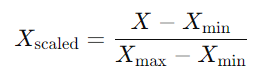

*   *X* es el valor original de la característica.
*   *Xmin* es el valor mínimo de la característica en el conjunto de datos.
*   *Xmax* es el valor máximo de la característica en el conjunto de datos.
*   *Xscaled* es el valor escalado.

In [124]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_train = X_train.select_dtypes(include=[np.number]).values
data_test = X_test.select_dtypes(include=[np.number]).values
data_prediction = predecir_X.select_dtypes(include=[np.number]).values

X_train_minmaxscaled = scaler.fit_transform(data_train)
X_test_minmaxscaled = scaler.fit_transform(data_test)
X_prediction_minmaxscaled = scaler.fit_transform(data_prediction)

print(X_train_minmaxscaled)
print(X_prediction_minmaxscaled)

[[0.82352941 0.         1.         ... 0.         0.         0.        ]
 [0.61764706 0.         1.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.16176471 1.         0.         ... 0.         1.         0.        ]
 [0.44117647 0.         0.33333333 ... 0.         0.         0.        ]
 [0.35294118 0.         0.33333333 ... 1.         0.         0.        ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [125]:
data_train.shape

(103, 21)

In [126]:
predecir_X.select_dtypes(include="object")

""
0


#### StandardScaler o Z-Score Normalization

Ajusta los datos para que tengan una media de 0 y una desviación típica de 1.

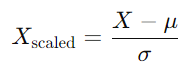

*    X es el valor original de la característica.
*    μ es la media de la característica en el conjunto de datos.
*    σ es la desviación estándar de la característica en el conjunto de datos.
*    X scaled es el valor escalado.

In [127]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_train = X_train.select_dtypes(include=[np.number]).values
data_test = X_test.select_dtypes(include=[np.number]).values
data_prediction = predecir_X.select_dtypes(include=[np.number]).values

X_train_scaled = scaler.fit_transform(data_train)
X_test_scaled = scaler.transform(data_test)
X_prediction_scaled = scaler.fit_transform(data_prediction)

In [128]:
X_test_scaled

array([[-1.22050542, -0.248708  , -0.99825077,  0.62630254, -1.33033001,
         0.18397059, -0.99033794, -1.48666153, -0.61101009, -0.54653783,
        -0.43992572, -0.27059299, -1.46452235, -1.55412834, -0.65616732,
         0.95257934,  1.3938641 , -0.71743005, -0.49088069, -0.30942637,
        -0.22587698],
       [-0.03347609, -0.248708  , -0.08021658, -0.73178507,  0.02634317,
        -1.03854366,  1.00975633, -0.35239384, -0.61101009, -0.54653783,
        -0.43992572, -0.27059299, -0.26733345, -0.84268292,  1.52400152,
        -1.04978132,  1.3938641 , -0.71743005, -0.49088069, -0.30942637,
        -0.22587698],
       [ 0.75787679, -0.248708  ,  0.83781761,  0.62630254,  0.02634317,
         2.01774197, -0.99033794,  0.78187384, -0.61101009, -0.54653783,
        -0.43992572, -0.27059299,  0.92985546, -0.84268292,  1.52400152,
        -1.04978132, -0.71743005, -0.71743005,  2.03715488, -0.30942637,
        -0.22587698],
       [-0.42915253, -0.248708  ,  1.75585181,  0.62630254

#### PCA

Alternativamente se puede realizar un Análisis de Componentes Principales para seleccionar los componentes (factores subyacentes) con mayor potencial predictivo (que explican aproximadamente lo mismo que las variables originales) y aligerar así el dataframe que vamos a pasar por los modelos de ML.

In [129]:
from sklearn.decomposition import PCA

features = df.select_dtypes(include=[np.number])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA()
pca.fit(scaled_features)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance Ratio:", cumulative_variance)

Explained Variance Ratio: [0.15435832 0.11473742 0.08935936 0.08599365 0.06958755 0.0615002
 0.05358684 0.05257603 0.04647468 0.04468223 0.03735303 0.03524924
 0.029933   0.02469907 0.02108074 0.01934396 0.01878566 0.01513539
 0.01230241 0.00740112 0.00371552 0.00214458]
Cumulative Explained Variance Ratio: [0.15435832 0.26909574 0.3584551  0.44444875 0.5140363  0.5755365
 0.62912334 0.68169937 0.72817405 0.77285628 0.81020931 0.84545855
 0.87539155 0.90009063 0.92117137 0.94051532 0.95930098 0.97443637
 0.98673878 0.9941399  0.99785542 1.        ]


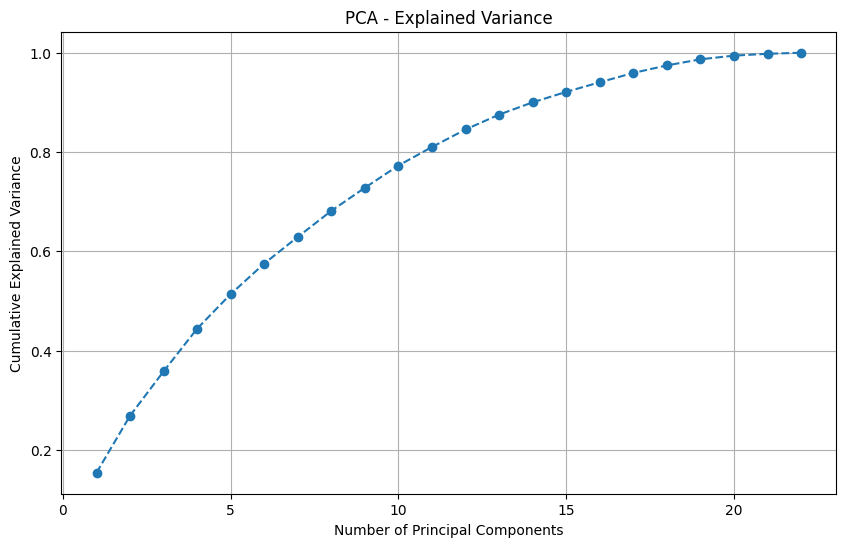

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

Vemos que el primer componente principal sólo constituye el 21% de la varianza, necesitamos sumar los 4 primeros para llegar al 50% y los 8 primeros para llegar al 80%. Esto significa que no hay dos o tres variables que influyan de manera importante en la predicción sino que todas las variables aportan más o menos la misma "cantidad" de información. Por lo tanto no podemos seguir por esta vía ya que no tiene sentido elegir los 8 primeros componentes sobre 15 para poder obtener un resultado coherente. Lo comprobamos haciendo cross-validation con los componentes principales:

In [131]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# PCA with 7 components
pca_7 = PCA(n_components=7)
X_train_pca_7 = pca_7.fit_transform(X_train_scaled)

model = LogisticRegression()
scores_7 = cross_val_score(model, X_train_pca_7, y_train, cv=3)

print(f"Mean cross-validation score with 8 components: {scores_7.mean():.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Mean cross-validation score with 8 components: 0.0387


In [132]:
# PCA with 12 components
pca_12 = PCA(n_components=12)
X_train_pca_12 = pca_12.fit_transform(X_train_scaled)

scores_12 = cross_val_score(model, X_train_pca_12, y_train, cv=3)

print(f"Mean cross-validation score with 12 components: {scores_12.mean():.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Mean cross-validation score with 12 components: 0.0387


Estas mean-scores tan sumamente bajos predicen que el modelo funcionará MUY mal con los datos de test.

### Crear y entrenar Caja Negra

#### Última verificación para asegurarnos que no hay valores nulos

In [133]:
import numpy as np

columns_with_nan_X_train = np.where(np.isnan(X_train).any(axis=0))[0]
columns_with_nan_names_X_train = column_names[columns_with_nan_X_train]
# print(X_train[:, columns_with_nan_X_train])
print(f"Columnas con valores nulos en X_train: {columns_with_nan_names_X_train}")

columns_with_nan_X_test = np.where(np.isnan(X_test).any(axis=0))[0]
columns_with_nan_names_X_test = column_names[columns_with_nan_X_test]
# print(X_test[:, columns_with_nan_X_test])
print(f"Columnas con valores nulos en X_test: {columns_with_nan_names_X_test}")

Columnas con valores nulos en X_train: Index([], dtype='object')
Columnas con valores nulos en X_test: Index([], dtype='object')


#### Cheatsheet para interpretar los resultados obtenidos por cada algoritmo

De manera general, se puede decir que:

**Sesgo:** Un sesgo elevado indica que el modelo no se ajusta lo suficiente, es decir, que es demasiado simple para captar los patrones subyacentes en los datos.

**Varianza:** Una varianza elevada indica que el modelo está sobreajustado, es decir, que es demasiado complejo y capta el ruido junto con la señal.

---

**Sesgo Bajo y Varianza Alta:**
- Error de Entrenamiento:  1% (**bajo**)
- Error de Prueba: 10% (**mucho mayor al de entrenamiento**)

**Sesgo Alto y Varianza Baja:**
- Error de Entrenamiento: 15% (**alto**)
- Error de Prueba: 16% (**similar al de entrenamiento**)

**Sesgo Alto y Varianza Alta:**
- Error de Entrenamiento: 15% (**alto**)
- Error de Prueba: 30% (**mucho mayor al de entrenamiento**)

**Sesgo Bajo y Varianza Baja (lo que buscamos):**
- Error de Entrenamiento:  0.5% (**bajo**)
- Error de Prueba:  1.0% (**bajo**)

El objetivo es obtener los errores de Entrenamiento y Prueba bajos.

- El **Error de Entrenamiento alto** (tambien conocido como **Underfitting** en ingles) puede estar dado por una de las siguientes condiciones:
  - Necesitamos mas datos para entrenar nuestra caja negra
  - Necesitamos una caja negra que pueda predecir datos complejos, por ejemplo los ensambles pueden predecir datos mas complejos que una regresion lineal porque no asumen ninguna hipotesis respecto a los datos.
- El **Error de Prueba alto** (tambien conocido como **Overfitting** en ingles) puede estar dado por una de las siguientes condiciones:
  - Necesitamos mas datos para entrenar nuestra caja negra
  - Necesitamos una caja negra mas simple o un metodo para evitar que la caja negra se ajuste demasiado a los datos de prueba. Estos metodos se llaman de **regularizacion**

---

**CÓMO INTERPRETAR EL MSE, EL RMSE Y EL R2**

El **Mean Squared Error (MSE)** es una métrica que mide el promedio de los errores cuadrados entre las predicciones del modelo y los valores reales. Se calcula como:

  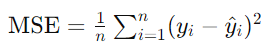

Donde:

*   𝑦𝑖 es el valor real,
*   𝑦^𝑖 es el valor predicho por el modelo,
*   𝑛 es el número total de observaciones.

Un MSE más alto indica un peor desempeño del modelo, ya que significa que los errores de predicción son más grandes en promedio. En general, un MSE bajo es deseable.

El **Root Mean Squared Error (RMSE)** es la raíz cuadrada del MSE y proporciona una medida de error en las mismas unidades que la variable dependiente. Se calcula como:

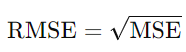

Para interpretar el RMSE, es útil compararlo con el rango de los datos y la escala de los valores. Si el RMSE es una fracción significativa del rango de los valores, podría indicar un problema con el modelo. Sin embargo, si es pequeño en comparación con el rango de los datos, el modelo puede estar funcionando bien.

El **R² (Coeficiente de Determinación)** es una métrica utilizada para evaluar la calidad de un modelo de regresión. A diferencia del MSE y RMSE, que miden la magnitud del error, el R² indica qué proporción de la variabilidad en la variable dependiente (objetivo) es explicada por el modelo. Se calcula como:

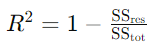

Donde:

**SSres (Sum of Squares of Residuals):** Es la suma de los cuadrados de las diferencias entre los valores observados y los valores predichos por el modelo.
**SStot (Total Sum of Squares):** Es la suma de los cuadrados de las diferencias entre los valores observados y la media de los valores observados.

*   R² = 1: Indica que el modelo explica el 100% de la variabilidad en la variable dependiente. Las predicciones del modelo coinciden perfectamente con los valores observados. Sin embargo, no siempre un R² alto es sinónimo de un buen modelo, especialmente si el modelo está sobreajustado (overfitting).
*   R² = 0: Indica que el modelo no explica ninguna variabilidad en la variable dependiente. El modelo no es mejor que simplemente predecir la media de los valores observados. Un valor bajo de R² (cercano a 0) indica que el modelo no captura bien la variabilidad de los datos, lo que podría significar que el modelo es demasiado simple o que las relaciones entre las variables no son lineales.
*   R² < 0: Puede ocurrir si el modelo es peor que una simple media (por ejemplo, si el modelo predice muy mal los datos). En este caso, el modelo está subajustando (underfitting).

**Limitaciones del R²**

No Detecta Sobreajuste: Un R² alto puede ser engañoso, ya que no indica si el modelo está sobreajustado. Por ejemplo, añadir variables irrelevantes al modelo puede aumentar el R² sin mejorar realmente la capacidad de generalización del modelo.
No Aplicable a Modelos No Lineales: R² se interpreta mejor en modelos lineales. En modelos no lineales, su interpretación puede ser menos directa.

**R² Ajustado**

Una versión ajustada del R² tiene en cuenta el número de predictores en el modelo. Esto es útil cuando se comparan modelos con diferente número de variables, ya que penaliza la adición de variables que no mejoran significativamente el modelo.


### 🔶 **RANDOM FOREST REGRESSOR** 🔶

#### ENTRENAR MODELO: Random Forest Regressor

(Voy a ignorar los parámetros siguientes ya que parece que no me aportan demasiado y ralentizan mucho el grid search: min_samples_split=3, min_samples_leaf=2 y max_features='sqrt')

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [20, 25, 30, 35, 40]
# }

# grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

model_rf = RandomForestRegressor(n_estimators=200, max_depth=20)
model_rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [135]:
train_pred = model_rf.predict(X_train_scaled)
print(train_pred)

[239253.75  272933.375 253552.75  117640.    228434.    206701.645
 187326.5   191679.56  198602.79  170079.5   190148.125 152485.
 259402.925 238429.    274581.405 204535.375 151041.5   235192.935
 169176.    214121.75  258882.78  196685.5   245749.75  256738.
 183002.645 236671.03  222322.    216719.895 266126.    206628.5
 204083.375 154948.435 266705.09  246174.53  182438.5   188646.975
 234237.25  223107.935 185782.145 257575.53  157103.645 191866.645
 206199.935 231446.16  208712.    265476.75  271933.05  229737.5
 161435.5   162463.    259263.195 267222.25  151379.5   173783.56
 184677.435 225608.25  273301.155 137107.    261637.5   247597.125
 131180.5   207683.79  209840.555 265681.5   189470.125 246818.5
 190943.5   262464.75  206856.    269957.53  215410.    206471.145
 248017.75  188350.395 216156.5   211761.03  191052.595 239262.25
 250720.625 179019.765 205970.625 220680.34  164979.5   272397.215
 268820.25  183655.145 253043.5   133440.    210251.645 273396.5
 227250.645

Predicción de tabla de prueba

In [136]:
test_pred = model_rf.predict(X_test)
print(test_pred)

[242052.25 250890.5  243011.   246690.03 235609.25 260880.78 246957.75
 233164.5  242879.25 230987.5  244777.75 241764.5  241721.25 236358.
 241905.5  231974.75 230183.5  235553.   221405.5  234042.5  246216.28
 234482.5  226199.5  244186.25 245171.28 247747.5  254660.78 245409.
 236510.   237592.5  235911.25 241358.5  233493.75 236171.5  243155.53
 256565.53 229762.75 242999.75 246676.75 222953.75 229823.5  245250.5
 230221.25 246751.75 233825.  ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [137]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 205280647.46
Root Mean Squared Error (RMSE): 14327.62


Coeficiente de Determinación R2

In [138]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.92


In [139]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

print(errors_train)

           MSE     RMSE   R2
0 205280647.46 14327.62 0.92


###### Error de prueba

MSE y RMSE

In [140]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 3492367888.3
Root Mean Squared Error (RMSE): 59096.26


Coeficiente de Determinación R2

In [141]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_test}")

Coeficiente de Determinación R2: -0.17


In [142]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [143]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

random_forest_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
random_forest_df.insert(0, 'Model', 'Random Forest Regressor')
random_forest_df.head(2)

,Model,MSE,RMSE,R2,set
0,Random Forest Regressor,205280647.46,14327.62,0.92,train
1,Random Forest Regressor,3492367888.30,59096.26,-0.17,test


###### Cross Validation

In [144]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_rf, X_train_scaled, y_train, cv=5)  # cv=5 indica 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.40473132 0.36688368 0.51830673 0.42289095 0.27081578]
Mean score: 0.3967256923267922
Standard deviation: 0.08034240492095178


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **DECISSION TREE REGRESSOR** 🔶

#### ENTRENAR MODELO: Decission Tree Regressor

In [145]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# grid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", -grid_search.best_score_)

model_dt = DecisionTreeRegressor(
    max_depth=2,
    # max_depth=5,
    # max_features='auto
    # max_features='sqrt',
    # min_samples_leaf=10,
    # min_samples_split=20
)

model_dt.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=2)

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [146]:
train_pred = model_dt.predict(X_train_scaled)
print(train_pred)

[248990.32258065 248990.32258065 248990.32258065 138125.
 248990.32258065 223189.11111111 248990.32258065 223189.11111111
 187852.63157895 187852.63157895 248990.32258065 138125.
 223189.11111111 248990.32258065 248990.32258065 223189.11111111
 138125.         223189.11111111 187852.63157895 223189.11111111
 223189.11111111 248990.32258065 248990.32258065 223189.11111111
 187852.63157895 223189.11111111 187852.63157895 223189.11111111
 248990.32258065 187852.63157895 223189.11111111 187852.63157895
 248990.32258065 223189.11111111 187852.63157895 223189.11111111
 248990.32258065 223189.11111111 223189.11111111 223189.11111111
 187852.63157895 223189.11111111 187852.63157895 223189.11111111
 187852.63157895 248990.32258065 223189.11111111 223189.11111111
 187852.63157895 138125.         223189.11111111 248990.32258065
 187852.63157895 223189.11111111 223189.11111111 248990.32258065
 248990.32258065 138125.         248990.32258065 248990.32258065
 138125.         223189.11111111 223189.1

Predicción de tabla de prueba

In [147]:
test_pred = model_dt.predict(X_test)
print(test_pred)

[248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065 248990.32258065 248990.32258065 248990.32258065
 248990.32258065]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [148]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 1467821941.08
Root Mean Squared Error (RMSE): 38312.16


Coeficiente de Determinación R2

In [149]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.4


In [150]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [151]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 3988822637.11
Root Mean Squared Error (RMSE): 63157.13


Coeficiente de Determinación R2

In [152]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

# Cálculo de R² Ajustado
n = len(y_test)  # Número de muestras
p = X_test.shape[1]  # Número de predictores (columnas en X_train)

r2_adjusted_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

# Redondeo de los resultados para presentarlos
r2_test = r2_test.round(2)
r2_adjusted_test = r2_adjusted_test.round(2)

print(f"Coeficiente de Determinación R²: {r2_test}")
print(f"Coeficiente de Determinación R² Ajustado: {r2_adjusted_test}")

Coeficiente de Determinación R²: -0.33
Coeficiente de Determinación R² Ajustado: -1.54


In [153]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [154]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

decission_tree_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
decission_tree_df.insert(0, 'Model', 'Decission Tree Regressor')
decission_tree_df.head(2)

,Model,MSE,RMSE,R2,set
0,Decission Tree Regressor,1467821941.08,38312.16,0.40,train
1,Decission Tree Regressor,3988822637.11,63157.13,-0.33,test


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **KNEIGHBORS REGRESSOR** 🔶

#### ENTRENAR MODELO: KNeighbors Regressor

In [155]:
from sklearn.neighbors import KNeighborsRegressor

model_knr = KNeighborsRegressor(
    n_neighbors=5       # Number of neighbors
   # weights='distance',    Use distance-weighted predictions
   # algorithm='auto',      Choose the algorithm
   # p=5                    Use Euclidean distance
)
model_knr.fit(X_train, y_train)

KNeighborsRegressor()

#### Validación cruzada (Cross Validation)

Decido realizar un análisis de Validación Cruzada ya que este algoritmo me está proporcionando resultados muy extraños. La validación cruzada divide el conjunto de datos en varios subconjuntos (pliegues) y entrena y prueba el modelo varias veces, utilizando cada vez un subconjunto diferente como conjunto de prueba y los subconjuntos restantes como conjunto de entrenamiento.

In [156]:
import numpy as np
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

cv_scores = cross_val_score(model_knr, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
std_cv_score = cross_val_score(model_knr, X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error').std()

mean_cv_score = -cv_scores.mean()
confidence_interval = stats.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=stats.sem(scores))

print(f"Cross-Validation mean: {mean_cv_score}")
print(f"Cross-Validation St_dev: {std_cv_score}")
print(f"Confidence Interval: {confidence_interval}")

Cross-Validation mean: 1778818235.9226105
Cross-Validation St_dev: 109708391.48900527
Confidence Interval: (0.2851925538854942, 0.5082588307680902)


Interpretación:

*   Promedio alto, desviación típica baja: el modelo es preciso y coherente, lo que sugiere una buena generalización.
*   Promedio alto, desviación típica alta: el modelo es preciso, pero puede estar sobreajustándose o ser sensible a subconjuntos específicos de datos.
*   Promedio bajo, desviación típica baja: el modelo tiene un rendimiento sistemáticamente bajo, lo que sugiere que podría estar ajustándose mal.
*   Promedio bajo, desviación típica alta: el modelo no es preciso ni coherente, lo que puede indicar problemas con la elección del modelo, la calidad de los datos o la necesidad de un mejor preprocesamiento.

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [157]:
train_pred = model_knr.predict(X_train_scaled)
print(train_pred)

[136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Predicción de tabla de prueba

In [158]:
test_pred = model_knr.predict(X_test_scaled)
print(test_pred)

[136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.
 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400. 136400.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [159]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 9062517493.22
Root Mean Squared Error (RMSE): 95197.26


Coeficiente de Determinación R2

In [160]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

# Cálculo de R² Ajustado
n = len(y_train)  # Número de muestras
p = X_train.shape[1]  # Número de predictores (columnas en X_train)

r2_adjusted_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)

# Redondeo de los resultados para presentarlos
r2_train = r2_train.round(2)
r2_adjusted_train = r2_adjusted_train.round(2)

print(f"Coeficiente de Determinación R²: {r2_train}")
print(f"Coeficiente de Determinación R² Ajustado: {r2_adjusted_train}")

Coeficiente de Determinación R²: -2.73
Coeficiente de Determinación R² Ajustado: -3.7


In [161]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [162]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 9541921171.84
Root Mean Squared Error (RMSE): 97682.76


Coeficiente de Determinación R2

In [163]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

# Cálculo de R² Ajustado
n = len(y_test)  # Número de muestras
p = X_test_scaled.shape[1]  # Número de predictores (columnas en X_train)

r2_adjusted_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

# Redondeo de los resultados para presentarlos
r2_test = r2_test.round(2)
r2_adjusted_test = r2_adjusted_test.round(2)

print(f"Coeficiente de Determinación R²: {r2_test}")
print(f"Coeficiente de Determinación R² Ajustado: {r2_adjusted_test}")

Coeficiente de Determinación R²: -2.19
Coeficiente de Determinación R² Ajustado: -5.1


In [164]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [165]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

kneighbors_regressor_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
kneighbors_regressor_df.insert(0, 'Model', 'KNeighbors Regressor')
kneighbors_regressor_df.head(2)

,Model,MSE,RMSE,R2,set
0,KNeighbors Regressor,9062517493.22,95197.26,-2.73,train
1,KNeighbors Regressor,9541921171.84,97682.76,-2.19,test


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **RIDGE REGRESSION** 🔶

#### ENTRENAR MODELO: Ridge Regression

In [166]:
from sklearn import linear_model
model_rr = linear_model.Ridge(alpha=1)
model_rr.fit(X_train_scaled, y_train)

Ridge(alpha=1)

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [167]:
train_pred = model_rr.predict(X_train_scaled)
print(train_pred)

[261790.03706395 215457.37065722 256388.36665606 142578.52465171
 282716.54246665 186623.28619557 188945.86971965 193632.18832778
 157297.57379394 174209.78659893 245085.4312253  165153.06861394
 226708.30446666 243699.30072605 262216.28115028 207710.4658459
 175218.95656164 216515.2504191  143914.98107776 213130.53111342
 229579.61794501 194668.41745245 235215.43061415 213660.04600937
 186082.75740066 234360.74187441 198594.56437688 234228.51156239
 240441.04718645 164331.24640852 197091.26968892 193197.89222899
 252168.65919086 230211.47495699 195390.9489572  232226.92238814
 250064.19124305 203377.40879268 200760.49611191 229378.39601843
 165171.24531647 210838.53072249 216638.99545525 196669.72558861
 204433.50662741 282593.53577764 236269.49873106 229600.0633085
 161706.9056384  181748.4702825  207740.20915826 226083.23532996
 176284.70572672 192212.20547039 175972.83623459 275870.431873
 261184.34819338 157605.76430072 270301.8740395  247659.6025458
 169453.19203802 239758.669182

Predicción de tabla de prueba

In [168]:
test_pred = model_rr.predict(X_test_scaled)
print(test_pred)

[184974.08516279 231992.83475857 260420.99240746 166329.2874541
 248412.34439395 164076.21861185 226019.57496096 193779.69976031
 178978.11769516 186377.34892979 222593.53841542 213366.81363265
 244306.56292834 265344.64792833 230671.22864775 212009.36386543
 196548.15638905 213870.62187679 159247.25530436 217720.48775071
 190265.93588379 216146.77152084 216183.93211965 301062.25531156
 173703.39656329 213918.65435385 197902.78619922 250185.66250461
 231999.4091086  167805.19843247 186351.99830016 229805.03579691
 187751.01125184 163584.28718848 153749.26452898 212964.33219448
 240820.89353625 285883.86538035 213888.82157686 187868.86455492
 197517.73310493 217733.6599005  242302.33509211 221407.40584248
 200665.27955958]


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [169]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 1250426356.22
Root Mean Squared Error (RMSE): 35361.37


Coeficiente de Determinación R2

In [170]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.49


In [171]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [172]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 2241060088.9
Root Mean Squared Error (RMSE): 47339.84


Coeficiente de Determinación R2

In [173]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_test}")

Coeficiente de Determinación R2: 0.25


In [174]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [175]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

ridge_regression_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
ridge_regression_df.insert(0, 'Model', 'Ridge Regression')
ridge_regression_df.head(2)

,Model,MSE,RMSE,R2,set
0,Ridge Regression,1250426356.22,35361.37,0.49,train
1,Ridge Regression,2241060088.90,47339.84,0.25,test


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **LASSO REGRESSION** 🔶

#### ENTRENAR MODELO: Lasso Regression

In [176]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [177]:
train_pred = model_lasso.predict(X_train_scaled)
print(train_pred)

[261657.62467445 215437.27802135 256486.58464306 140875.01940349
 282880.55150931 185960.97634705 188495.71704446 193280.83566957
 156276.14109962 174239.43771735 246050.84977693 164722.40378051
 226767.0005242  244541.94130072 262325.29061005 208917.88525683
 175306.00633429 216890.81990243 143367.76952277 213346.11476923
 229550.49967037 194158.54828817 235210.87865257 214067.82419827
 185383.92615474 233820.83259035 198604.80104165 234208.64931353
 239982.51896374 163495.88723108 196722.29927125 193662.04758913
 252020.51139801 230099.67321968 195310.98925779 232858.86226025
 250278.26037573 203486.76441462 200520.40057636 229703.66687178
 164170.83266529 210896.65322357 216645.13684103 195868.38667387
 204266.72444631 282706.53477826 237228.05395103 230062.17797726
 161070.0189143  181675.34815625 208328.42634109 225198.52440619
 175668.77516366 192032.45804134 175092.71968369 276098.90588469
 261293.96586479 157076.40021617 271287.2511496  247352.5681385
 168777.61379408 240343.28

Predicción de tabla de prueba

In [178]:
test_pred = model_lasso.predict(X_test_scaled)
print(test_pred)

[184730.5612184  232114.7988382  260657.88607567 165825.15537629
 248961.51314719 162950.80497112 225971.43577819 193772.99500721
 177696.36611943 185458.94734775 222718.43228504 213278.95635687
 243966.85826921 265627.64083454 231080.30227517 211974.23307892
 196918.93177681 213760.73577834 158493.46884884 217651.82497888
 189887.6112564  215451.783729   216708.71770735 302183.63658442
 173164.73911633 214171.84207255 197528.12707931 250561.32892564
 231685.54513257 166828.32016874 186343.5020848  231096.68125579
 187180.12311992 162499.30403788 152449.69767945 212191.89364377
 241062.7436438  286484.25434135 213536.79040636 188145.12860296
 197980.72562374 217787.06087896 242812.26119202 220876.98975649
 201256.56915554]


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [179]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 1250121619.47
Root Mean Squared Error (RMSE): 35357.06


Coeficiente de Determinación R2

In [180]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.49


In [181]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [182]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 2258083907.19
Root Mean Squared Error (RMSE): 47519.3


Coeficiente de Determinación R2

In [183]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_test}")

Coeficiente de Determinación R2: 0.24


In [184]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [185]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

model_lasso_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
model_lasso_df.insert(0, 'Model', 'Lasso Regression')
model_lasso_df.head(2)

,Model,MSE,RMSE,R2,set
0,Lasso Regression,1250121619.47,35357.06,0.49,train
1,Lasso Regression,2258083907.19,47519.30,0.24,test


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **ELASTIC NET REGRESSION** 🔶

#### ENTRENAR MODELO: Elastic Net Regression

In [186]:
from sklearn.linear_model import ElasticNet

model_enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_enet.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1)

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [187]:
train_pred = model_enet.predict(X_train_scaled)
print(train_pred)

[262031.78294168 215797.89036189 256309.85441167 148509.02915508
 281726.01925255 188687.88002482 190571.81655071 195595.55083171
 160968.02684362 174334.90845288 241973.88065835 166737.48814774
 226486.6032917  240869.41296183 261270.02823804 203958.69420597
 175037.49405461 215141.11695451 146159.02633879 212487.70711692
 229478.43261301 196728.29057615 234936.27663183 212353.10193162
 188465.35011181 235951.65093995 198598.00675609 234109.80701092
 241925.85952523 167465.01787513 198538.63311654 192292.40426801
 252557.01582001 230400.05859196 195668.9592208  230122.09155902
 249839.19741415 203279.64610369 201612.59352338 228344.94712538
 168645.25982707 210631.08345824 216450.49425874 199441.31083708
 204880.67265221 281663.5003484  232915.06719921 228054.35648303
 164168.01917645 182002.71985936 206473.79954361 229122.02235038
 178485.55936576 192958.71253486 178982.97787856 274957.71629359
 260605.05245247 159490.78769564 266942.81106482 248305.79072503
 171753.49444258 237616.6

Predicción de tabla de prueba

In [188]:
test_pred = model_enet.predict(X_test_scaled)
print(test_pred)

[185825.50189917 231474.44018662 259426.63734385 168897.67620488
 246700.83765561 167536.77783722 226118.15732594 193965.22713417
 183106.88967616 189596.69666382 222441.68944071 213653.51748732
 245080.28408123 264008.54780338 229137.96331702 212226.73293538
 195388.45930991 214302.00534305 162016.17787429 218036.00919063
 191432.6876142  218827.47788239 214250.9843572  296805.07995031
 175888.31974536 213072.99981993 199284.04236187 248343.62898802
 232978.1018507  171224.45588237 186460.78381352 225333.64253808
 189120.50572577 167331.01448057 158397.4728032  215548.65669723
 239821.04845417 284073.96191454 214871.82755786 187135.4041404
 195952.38732701 217697.51672763 240399.8737251  223581.48929519
 199069.07941075]


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [189]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 1256187145.06
Root Mean Squared Error (RMSE): 35442.73


Coeficiente de Determinación R2

In [190]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.48


In [191]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [192]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 2190287069.03
Root Mean Squared Error (RMSE): 46800.5


Coeficiente de Determinación R2

In [193]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_test}")

Coeficiente de Determinación R2: 0.27


In [194]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [195]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

elastic_net_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
elastic_net_df.insert(0, 'Model', 'Elastic Net Regression')
elastic_net_df.head(2)

,Model,MSE,RMSE,R2,set
0,Elastic Net Regression,1256187145.06,35442.73,0.48,train
1,Elastic Net Regression,2190287069.03,46800.50,0.27,test


<font color="red">Escribir conclusiones aquí.</font>

### 🔶 **LINEAR REGRESSION** 🔶

#### ENTRENAR MODELO: Linear Regression

In [196]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

LinearRegression()

#### Clasificacion de Cajas Negras por Algoritmo utilizado

##### Realizar predicción

Predicción de tabla de entrenamiento

In [197]:
train_pred = model_lr.predict(X_train_scaled)
print(train_pred)

[261656.38439111 215437.24544149 256487.0544969  140873.9295094
 282881.08689673 185959.0052828  188494.83189935 193281.63844323
 156274.79060849 174239.13941971 246050.93741573 164721.70397162
 226767.43623683 244542.31724693 262325.2575728  208919.03733595
 175305.98824811 216890.89217834 143367.20734711 213346.45196227
 229548.8855008  194157.55664361 235210.33477011 214068.36654156
 185383.54887677 233821.12309414 198605.56723629 234208.45810492
 239982.26106867 163494.87754764 196721.92603676 193663.52454198
 252019.32440073 230099.78325803 195310.76129339 232859.59340531
 250279.77349064 203487.13297186 200520.30602145 229704.95602575
 164169.9540742  210897.30330137 216644.98150042 195867.84767636
 204267.01566318 282707.47518603 237229.01240621 230062.23189501
 161069.73551365 181674.10028195 208330.99924254 225197.62203541
 175668.55706421 192032.7249083  175090.76598698 276099.72135711
 261294.84705196 157075.45283518 271287.95124772 247350.58973729
 168776.83247763 240343.55

Predicción de tabla de prueba

In [198]:
test_pred = model_lr.predict(X_test_scaled)
print(test_pred)

[184730.05749118 232114.76056796 260658.54427541 165825.49404184
 248961.64169308 162949.39777572 225971.74668075 193772.59872421
 177695.37399198 185458.91842912 222717.66589646 213279.51240432
 243965.98327171 265628.70406597 231081.10626979 211974.36832346
 196918.50997229 213761.37643963 158492.0111893  217651.63642204
 189886.11109867 215451.33079998 216708.89771345 302186.76140539
 173163.58325231 214171.45593233 197527.31471607 250561.3776235
 231685.51836357 166827.40526913 186343.51569827 231097.24982397
 187177.57243514 162497.92588993 152448.60008932 212191.10622972
 241063.401306   286484.56194652 213536.82426514 188145.36651083
 197980.80514888 217787.82398781 242813.368237   220876.16889795
 201256.18885671]


##### Calcular errores

###### Error de entrenamiento

MSE y RMSE

In [199]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, train_pred).round(2)
rmse_train = np.sqrt(mse_train).round(2)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")

Mean Squared Error (MSE): 1250121618.76
Root Mean Squared Error (RMSE): 35357.06


Coeficiente de Determinación R2

In [200]:
from sklearn import metrics

r2_train = metrics.r2_score(y_train, train_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_train}")

Coeficiente de Determinación R2: 0.49


In [201]:
errors_train = pd.DataFrame(
    {"MSE":[mse_train],
     "RMSE":[rmse_train],
     "R2":[r2_train]})

###### Error de prueba

MSE y RMSE

In [202]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(y_test, test_pred).round(2)
rmse_test = np.sqrt(mse_test).round(2)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")

Mean Squared Error (MSE): 2258108651.13
Root Mean Squared Error (RMSE): 47519.56


Coeficiente de Determinación R2

In [203]:
from sklearn import metrics

r2_test = metrics.r2_score(y_test, test_pred).round(2)

print(f"Coeficiente de Determinación R2: {r2_test}")

Coeficiente de Determinación R2: 0.24


In [204]:
errors_test = pd.DataFrame(
    {"MSE":[mse_test],
     "RMSE":[rmse_test],
     "R2":[r2_test]})

#### Comprobar que la Caja Negra esta bien entrenada - Sesgo y Varianza (Bias y Variance)

In [205]:
errors_train['set'] = 'train'
errors_test['set'] = 'test'

linear_regression_df = pd.concat([errors_train, errors_test], axis=0, ignore_index=True)
linear_regression_df.insert(0, 'Model', 'Linear Regression')
linear_regression_df.head(2)

,Model,MSE,RMSE,R2,set
0,Linear Regression,1250121618.76,35357.06,0.49,train
1,Linear Regression,2258108651.13,47519.56,0.24,test


<font color="red">Escribir conclusiones aquí.</font>

### Recapitulación de resultados de los diferentes tests

In [206]:
result_df = pd.concat([random_forest_df, decission_tree_df, kneighbors_regressor_df, ridge_regression_df, model_lasso_df, elastic_net_df, linear_regression_df], axis=0, ignore_index=True)
result_df[['MSE', 'RMSE', 'R2']] = result_df[['MSE', 'RMSE', 'R2']].round(2)
pd.options.display.float_format = '{:.2f}'.format
result_df

,Model,MSE,RMSE,R2,set
0,Random Forest Regressor,205280647.46,14327.62,0.92,train
1,Random Forest Regressor,3492367888.30,59096.26,-0.17,test
2,Decission Tree Regressor,1467821941.08,38312.16,0.40,train
3,Decission Tree Regressor,3988822637.11,63157.13,-0.33,test
4,KNeighbors Regressor,9062517493.22,95197.26,-2.73,train
5,KNeighbors Regressor,9541921171.84,97682.76,-2.19,test
6,Ridge Regression,1250426356.22,35361.37,0.49,train
7,Ridge Regression,2241060088.90,47339.84,0.25,test
8,Lasso Regression,1250121619.47,35357.06,0.49,train
9,Lasso Regression,2258083907.19,47519.30,0.24,test


Conclusiones generales: Vemos que incurrimos en Overfitting con todos los modelos, probablemente debido al tamaño demasiado reducido del dataset. Para mejorar estos resultados se puede jugar con los distintos parámetros de cada algoritmo o, también, se pueden implementar diferentes técnicas existentes:



In [207]:
print(X_train.shape[1])
X_train_scaled.shape

X_train.columns.tolist()

21


['area',
 'contact_is_private_seller',
 'district',
 'dpe',
 'estate_type',
 'ges',
 'is_exclusive',
 'rooms',
 'sold',
 'selling_time',
 'old_price',
 'price_decrease_percent',
 'bedrooms',
 'level',
 'balcony',
 'terrace',
 'parking',
 'elevator',
 'box',
 'garden',
 'swimming_pool']

#### Predicción del modelo RANDOM FOREST

In [208]:
predictions = model_rf.predict(X_prediction_scaled)
print(predictions)

[202078.455]


#### Predicción del modelo DECISSION TREE REGRESSOR

In [209]:
predictions = model_dt.predict(X_prediction_scaled)
print(predictions)

[223189.11111111]


#### Predicción del modelo K-NEIGHBORS REGRESSOR

In [210]:
predictions = model_knr.predict(X_prediction_scaled)
print(predictions)

[136400.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


#### Predicción del modelo RIDGE REGRESSION

In [211]:
predictions = model_rr.predict(X_prediction_scaled)
print(predictions)

[217829.22330097]


#### Predicción del modelo LINEAR REGRESSION

In [212]:
predictions = model_lr.predict(X_prediction_scaled)
print(predictions)

[217829.22330097]
